# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import shutil

from benchmarks.rm_dynamics import RailwayMarketDynamics

from pathlib import Path

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

Number of service requests generated: 15
{'03612_2024-06-25-17.40': {'60000': [1060, 1060], '71801': [1210, 1210]}, '02731_2024-06-25-13.32': {'60000': [812, 812], '04040': [887, 889], '71500': [962, 964], '71801': [997, 997]}, '03612_2024-06-25-21.27': {'60000': [1287, 1287], '71801': [1437, 1437]}, '02731_2024-06-25-17.27': {'60000': [1047, 1047], '04040': [1122, 1124], '71500': [1197, 1199], '71801': [1232, 1232]}, '02731_2024-06-25-15.44': {'60000': [944, 944], '04040': [1019, 1021], '71500': [1094, 1096], '71801': [1129, 1129]}, '03612_2024-06-25-18.05': {'60000': [1085, 1085], '71801': [1235, 1235]}, '03612_2024-06-25-18.25': {'60000': [1105, 1105], '71801': [1255, 1255]}, '04161_2024-06-25-13.52': {'60000': [832, 832], '70600': [887, 888], '04040': [913, 914], '78400': [957, 959], '71500': [986, 988], '71801': [1024, 1024]}, '03612_2024-06-25-22.57': {'60000': [1377, 1377], '71801': [1527, 1527]}, '03612_2024-06-25-19.12': {'60000': [1152, 1152], '71801': [1302, 1302]}, '03612_2

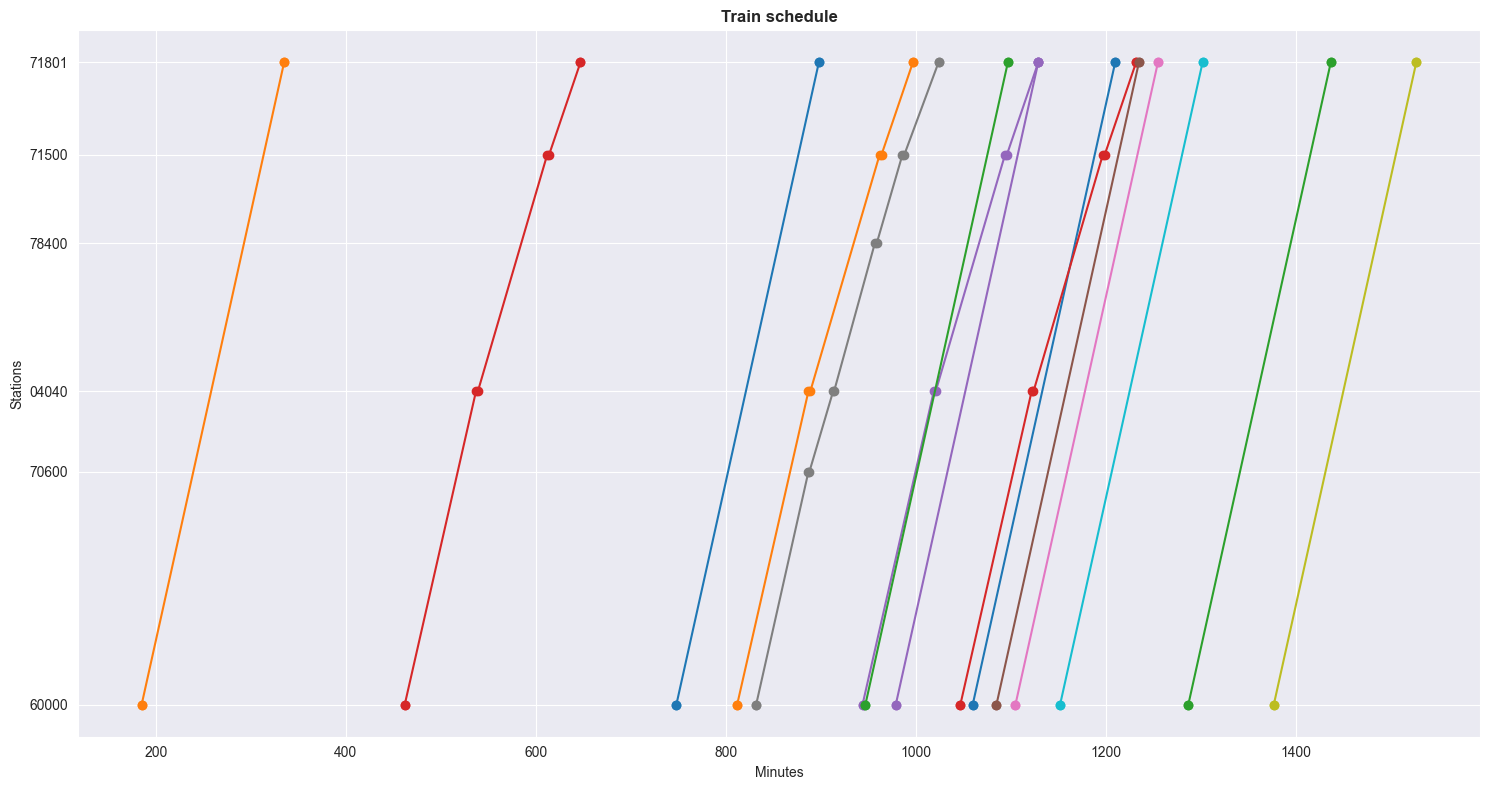

  0%|          | 0/11 [00:00<?, ?it/s]

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.)
1,2.0,2902.143901,9.153647,15.0,3.0,21.0
9,10.0,2900.547116,9.090124,15.0,10.0,10.0
4,5.0,2896.037183,9.151990,15.0,11.0,9.0
2,3.0,2886.590329,9.050345,15.0,8.0,20.0
6,7.0,2862.826833,9.091874,15.0,22.0,19.0
3,4.0,2861.190039,9.090414,15.0,9.0,26.0
10,11.0,2856.713337,9.075572,15.0,15.0,27.0
5,6.0,2836.736699,9.111835,15.0,9.0,33.0
7,8.0,2836.324710,9.249053,15.0,23.0,20.0
8,9.0,2827.762962,9.051593,15.0,20.0,24.0


Global GSA status:
	Total execution time: 100.0092 s.
	Execution Time (by run) - Mean: 9.0917 s. - Std: 0.0871 s.
	Revenue - Mean: 2860.9486 - Std: 32.8062
	Scheduled Trains - Mean: 15.0 - Std: 0.0
	Median solution: Run 4
	Max Revenue: 2959.0 - WARNING!: Scheduling all services could not be feasible


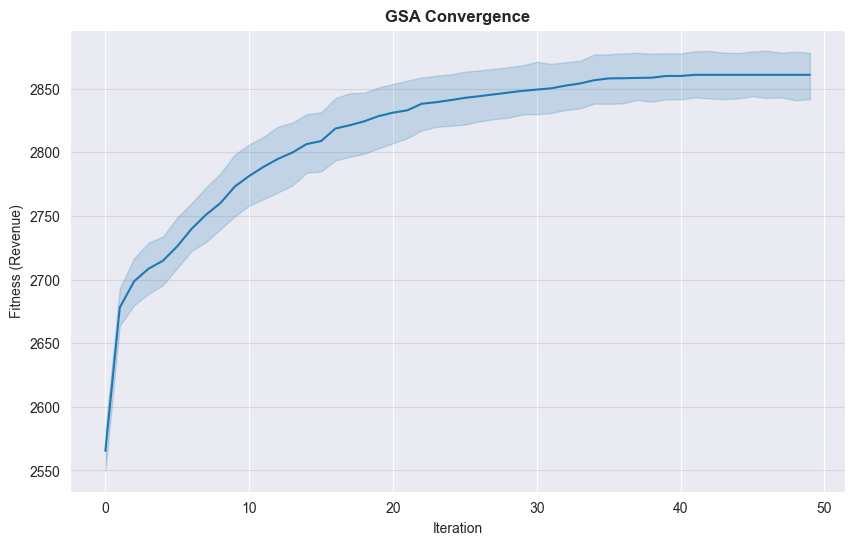

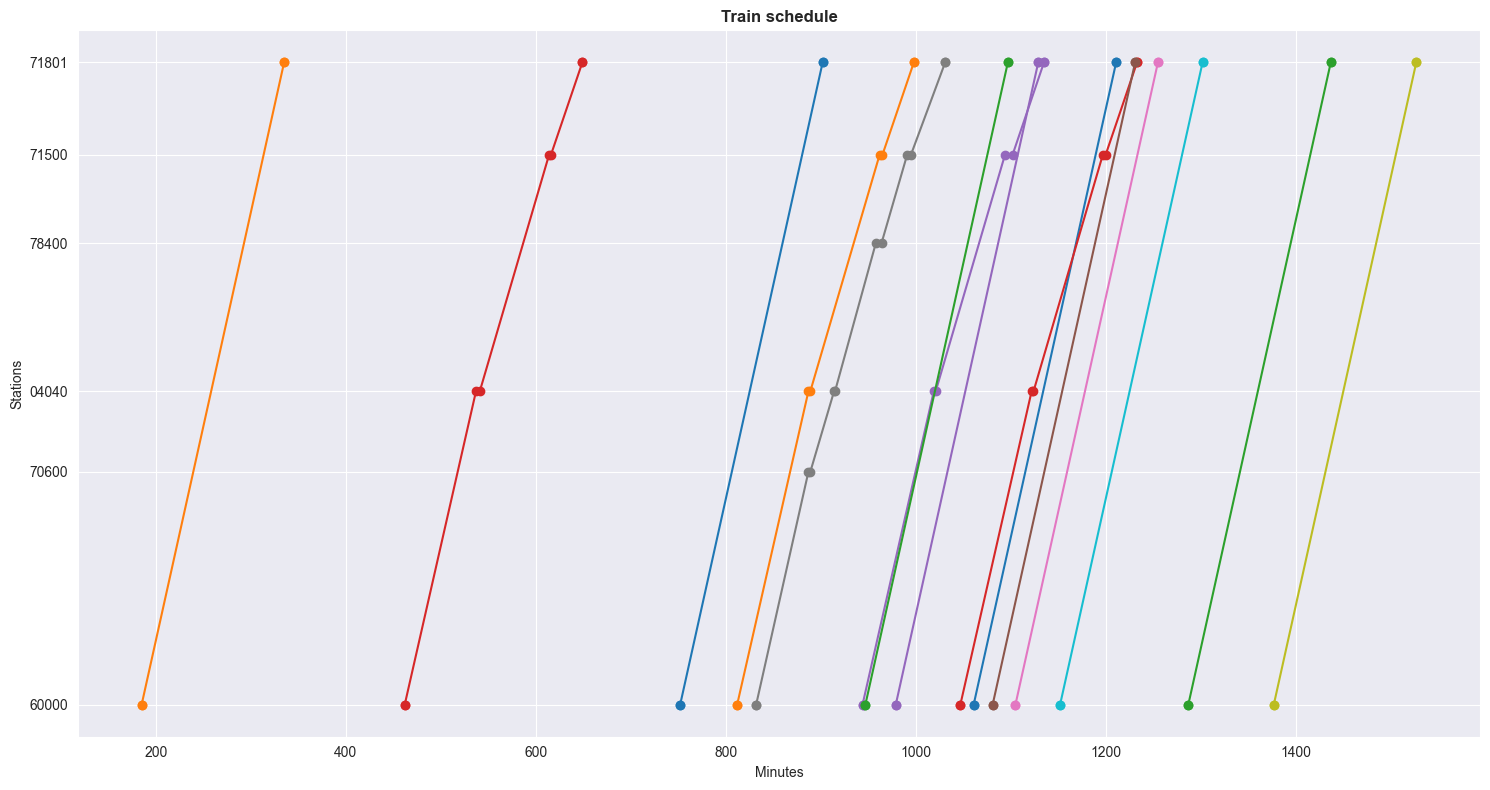

Data from demand plot: 
	Status: User bought a service which was not the one with the best utility. - Passengers: 4019
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 3112
	Status: User bought the ticket with best utility. - Passengers: 914
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4933
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 630 - Percentage: 12.77 %
		Seat: Turista - Passengers: 4003 - Percentage: 81.15 %
		Seat: Turista Plus - Passengers: 300 - Percentage: 6.08 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4933
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Turista - Number of tickets sold: 148
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 23
			Seat: Turista - Number of tickets sold: 119
		Date: 2023-06-13
			Seat: Premium - Number of tickets sold: 27
			Seat: Turist

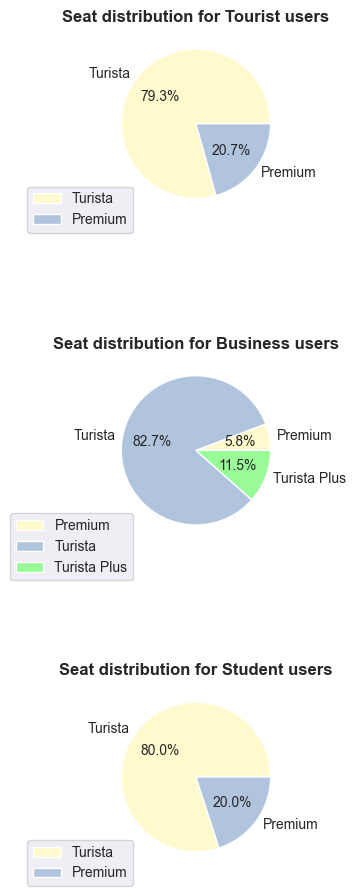

In [5]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path=generator_save_path,
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=f'{robin_save_path}output.yml',
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=11,
                    gsa_chaotic=True,
                    gsa_verbosity=False)

In [4]:
def detect_interference(schedule_data, safety_gap):
    train_ids = list(schedule_data.keys())
    num_trains = len(train_ids)
    interference_matrix = np.zeros((num_trains, num_trains), dtype=bool)

    # Comparar cada tren con todos los demás trenes
    for i, train_id1 in enumerate(train_ids):
        for j in range(i+1, num_trains):
            train_id2 = train_ids[j]
            for station in schedule_data[train_id1]:
                if station in schedule_data[train_id2]:
                    # Comprobar si los tiempos se superponen considerando el gap de seguridad
                    departure1 = schedule_data[train_id1][station][1] + safety_gap
                    arrival2 = schedule_data[train_id2][station][0]
                    departure2 = schedule_data[train_id2][station][1] + safety_gap
                    arrival1 = schedule_data[train_id1][station][0]
                    if arrival1 < departure2 or arrival2 < departure1:
                        interference_matrix[i][j] = True
                        interference_matrix[j][i] = True
                        break  # No necesitamos más comprobaciones si ya hay interferencia
    return interference_matrix

In [10]:
from robin.demand.entities import Demand

demand = Demand.from_yaml('../configs/demand/demand.yml')

In [11]:
passengers = demand.generate_passengers()

In [12]:
p = passengers[0]

In [19]:
values = [float(rule.split(' ')[-1]) for r, rule in p.user_pattern._rules.items()]
values

[30.0, 40.0, 30.0]

In [44]:
import random

def update_rules(values: list, max_change: int=2):
    for _ in range(len(values)):
        # Set two random indexes
        idx1, idx2 = random.sample(range(len(values)), 2)
        
        # Calculate the amount of change
        cambio = np.round(random.uniform(1, min(max_change, values[idx1], values[idx2])))
        
        # Adjust the values
        values[idx1] -= cambio
        values[idx2] += cambio    
    return values

# Original
original = [30.0, 40.0, 30.0]

updated = update_rules(original.copy())
updated

[29.0, 37.0, 34.0]

100.0


MAD-ZAR: 271.94 km
ZAR-BAR: 256.65 km
BAR-FIG: 118.84 km
{'MAD': 0, 'ZAR': 271.94047335680744, 'BAR': 528.5857165755872, 'FIG': 647.4297319783497}
{'MAD': 0.0, 'ZAR': 420.03, 'BAR': 816.44, 'FIG': 1000.0}


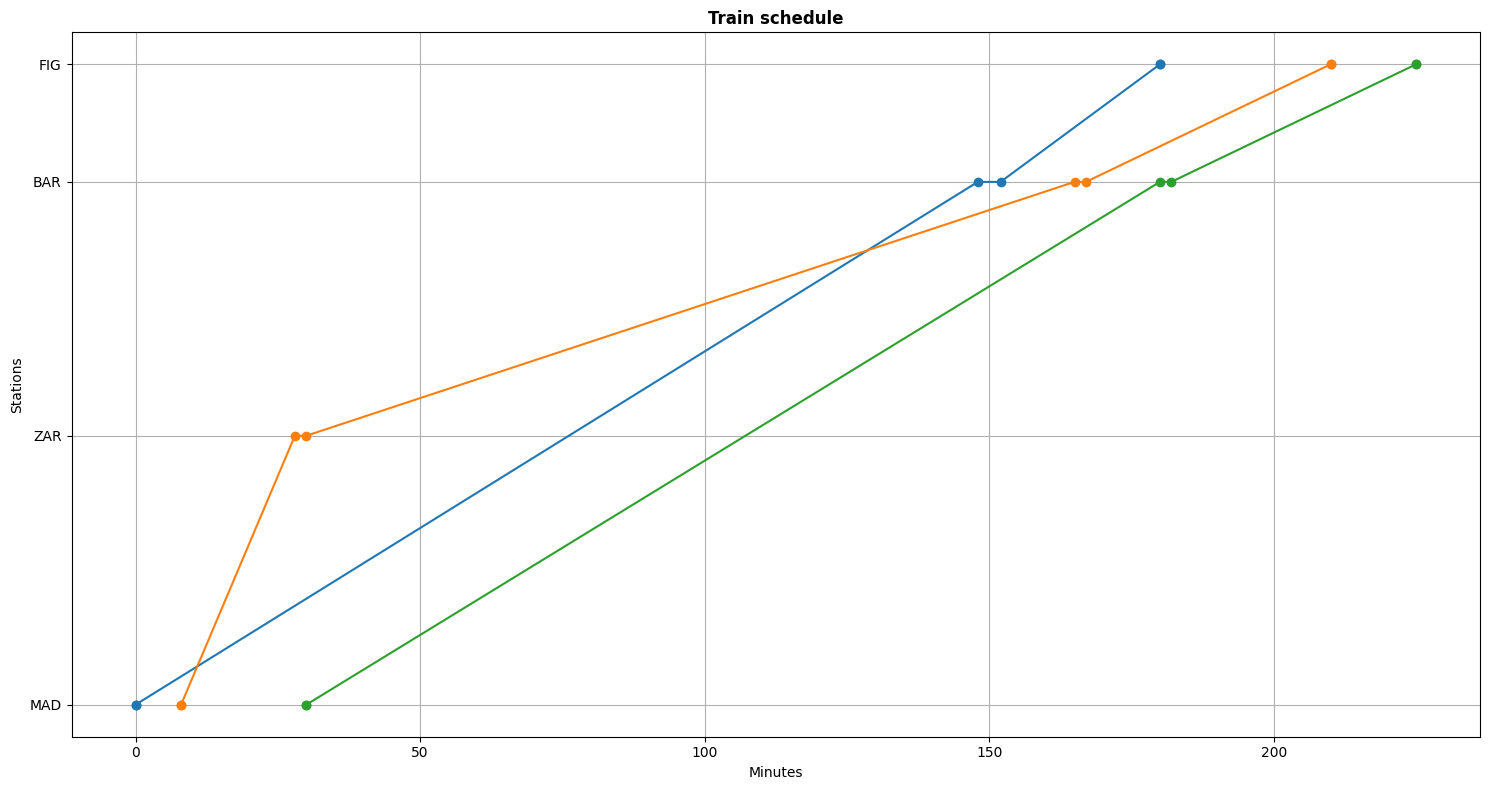

In [17]:
from benchmarks.utils import TrainSchedulePlotter

schedule = {0: {'MAD': (0, 0), 'ZAR': (50, 50), 'BAR': (90, 90)},
            1: {'ZAR': (70, 70), 'BAR': (110, 110)},
            2: {'MAD': (20, 20), 'BAR': (40, 40)}}

schedule = {1: {'MAD': [0, 0], 'BAR': [148, 152], 'FIG': [180, 180]},
            2: {'MAD': [8, 8], 'ZAR': [28, 30], 'BAR': [165, 167], 'FIG': [210, 210]},
            3: {'MAD': [30, 30], 'BAR': [180, 182], 'FIG': [225, 225]}}

line_stations = {'MAD': (40.406442, -3.690886),
                 'ZAR': (41.658649, -0.911615),
                 'BAR': (41.37922, 2.140624),
                 'FIG': (42.264771, 2.943547)}

schedule_plotter = TrainSchedulePlotter(schedule, line_stations)
print(schedule_plotter.station_positions)
schedule_plotter.plot()

In [47]:
def infer_station_order(schedule):
    trips = [list(trip.keys()) for trip in schedule.values()]
    line = trips.pop(trips.index(max(trips, key=len)))

    for trip in trips:
        for i, s in enumerate(trip):
            if s not in line:
                line.insert(line.index(trip[i + 1]), s)

    return {sta: i for i, sta in enumerate(line)}

line_stations = infer_station_order(schedule)
line_stations

{'MAD': 0, 'ZAR': 1, 'BAR': 2}

In [48]:
schedule_matrix = []
for service in schedule:
    row = []
    for station, _ in line_stations.items():
        if station not in schedule[service]:
            row.append(np.nan)
        else:
            row.append(schedule[service][station])
    schedule_matrix.append(row)
            
print(schedule_matrix)

[[(0, 0), (50, 50), (90, 90)], [nan, (70, 70), (110, 110)], [(20, 20), nan, (40, 40)]]


In [49]:
from shapely.geometry import Polygon, LineString, Point, MultiPoint

def get_closest_station(station, line_stations, other_service_stations):
    station_idx = line_stations[station]
    closest_station = None
    min_distance = float('inf')
    for other_station in other_service_stations:
        other_station_idx = line_stations[other_station]
        distance = abs(station_idx - other_station_idx)
        if distance < min_distance:
            min_distance = distance
            closest_station = other_station
    return closest_station

conflict_matrix = np.zeros((len(schedule), len(schedule)), dtype=np.bool_)

security_gap = 10
train_gap = np.ceil(security_gap // 2)
for i, service in enumerate(schedule):
    print(f"Service {service}, {i}")
    service_stations = tuple(schedule[service].keys())
    for k, station in enumerate(service_stations):
        if k == len(service_stations) - 1:
            break
        
        segment = Polygon([(schedule[service][station][1] - train_gap, line_stations[station]),
                           (schedule[service][service_stations[k + 1]][0] - train_gap, line_stations[service_stations[k + 1]]),
                           (schedule[service][service_stations[k + 1]][0] + train_gap, line_stations[service_stations[k + 1]]),
                           (schedule[service][station][1] + train_gap, line_stations[station])])
        for j, other_service in enumerate(tuple(schedule.keys())[i+1:], start=i+1):
            print(f"Other service {other_service}, {j}")
            if other_service == service:
                continue
            other_service_stations = tuple(schedule[other_service].keys())
            other_service_init = station if station in other_service_stations else get_closest_station(station,
                                                                                                       line_stations, other_service_stations)
            
            if other_service_init == other_service_stations[-1] or line_stations[other_service_init] >= line_stations[service_stations[k + 1]]:
                continue
             
            other_service_end = other_service_stations[other_service_stations.index(other_service_init) + 1]
            other_segment = Polygon([(schedule[other_service][other_service_init][1] - train_gap, line_stations[other_service_init]),
                                     (schedule[other_service][other_service_end][0] - train_gap, line_stations[other_service_end]),
                                     (schedule[other_service][other_service_end][0] + train_gap, line_stations[other_service_end]),
                                     (schedule[other_service][other_service_init][1] + train_gap, line_stations[other_service_init])])
            
            intersection = segment.intersection(other_segment)
            if intersection and type(intersection) == Polygon:
                print(f"{i}{j}")
                conflict_matrix[i][j] = True
                conflict_matrix[j][i] = True
                print(f"Conflict between {service} and {other_service} at {intersection}")
                
print(conflict_matrix)

Service 0, 0
Other service 1, 1
Other service 2, 2
02
Conflict between 0 and 2 at POLYGON ((32.5 0.75, 30 0.5, 17.5 0.25, 20 0.5, 32.5 0.75))
Other service 1, 1
Other service 2, 2
Service 1, 1
Other service 2, 2
Service 2, 2
[[False False  True]
 [False False False]
 [ True False False]]


In [55]:
S_i = np.array([True, True, True], dtype=np.bool_)

new_matrix = S_i * conflict_matrix
new_matrix

array([[False, False,  True],
       [False, False, False],
       [ True, False, False]])

In [56]:
filtered_matrix = new_matrix[S_i]
filtered_matrix

array([[False, False,  True],
       [False, False, False],
       [ True, False, False]])

In [57]:
np.any(filtered_matrix)

True

In [58]:
np.any((S_i * conflict_matrix)[S_i])

True

In [59]:
np.array([(~cm).all() for cm in conflict_matrix], dtype=np.bool_)

array([False,  True, False])

In [66]:
indexer = {s: i for i, s in enumerate(schedule)}

s = 0
np.where(conflict_matrix[s])[0]

array([2])